In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
from zipfile import ZipFile
dataset = '/content/data.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
base_dir = '/content/data'
with_mask_files = os.listdir('/content/data/with_mask')
print(with_mask_files[0:5])
print(with_mask_files[-5:])
without_mask_files = os.listdir('/content/data/without_mask')
print(without_mask_files[0:5])
print(without_mask_files[-5:])

['with_mask_1550.jpg', '3246.jpg', '977.jpg', '4684.jpg', 'with_mask_2281.jpg']
['with_mask_2443.jpg', '350.jpg', '4312.jpg', '3729.jpg', '2115.jpg']
['3246.jpg', '977.jpg', '4684.jpg', '488.jpg', 'without_mask_3284.jpg']
['without_mask_1492.jpg', 'without_mask_1724.jpg', '3729.jpg', 'without_mask_2004.jpg', '2115.jpg']


In [ ]:
print("Number of with mask images:", len(with_mask_files))
print("Number of without mask images:", len(without_mask_files))

Number of with mask images: 9246
Number of without mask images: 9349


In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 14877 images belonging to 2 classes.


In [ ]:
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print(f"Class indices: {train_generator.class_indices}")

Found 3718 images belonging to 2 classes.
Class indices: {'with_mask': 0, 'without_mask': 1}


**MODEL ARCHITECTURE - Transfer Learning with MobileNetV2**

In [ ]:
def create_improved_model():

    # Loading pre-trained MobileNetV2 model

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )


    base_model.trainable = False

    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model, base_model

**Creating model**

In [ ]:
model, base_model = create_improved_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Compiling the model**

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,041 (9.27 MB)

 Trainable params: 172,673 (674.50 KB)

 Non-trainable params: 2,258,368 (8.61 MB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_mask_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

**Training the model (Phase - 1 : Training only top layers)**

In [ ]:
print("Phase 1: Training top layers only...")
history_phase1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Phase 1: Training top layers only...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
137/465 ━━━━━━━━━━━━━━━━━━━━ 2:38 483ms/step - accuracy: 0.8863 - loss: 0.2588 - precision: 0.8859 - recall: 0.8854

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9369 - loss: 0.1541 - precision: 0.9369 - recall: 0.9366
Epoch 1: val_accuracy improved from -inf to 0.97337, saving model to best_mask_model.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 237s 465ms/step - accuracy: 0.9369 - loss: 0.1540 - precision: 0.9370 - recall: 0.9366 - val_accuracy: 0.9734 - val_loss: 0.0714 - val_precision: 0.9972 - val_recall: 0.9497 - learning_rate: 0.0010
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9786 - loss: 0.0599 - precision: 0.9789 - recall: 0.9789
Epoch 2: val_accuracy improved from 0.97337 to 0.97714, saving model to best_mask_model.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 222s 411ms/step - accuracy: 0.9786 - loss: 0.0599 - precision: 0.9789 - recall: 0.9789 - val_accuracy: 0.9771 - val_loss: 0.0594 - val_precision: 0.9725 - val_recall: 0.9823 - learning_rate: 0.0010
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9826 - loss: 0.0537 - precision: 0.9839 - recall: 0.9819
Epoch 3: val_accuracy improved from 0.97714 to 0.98736, saving model to best_mask_model.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 186s 400ms/step - accuracy: 0.9826 - loss: 0.0537 - precision: 0.9839 - recall: 0.9819 - val_accuracy: 0.9874 - val_loss: 0.0370 - val_precision: 0.9962 - val_recall: 0.9786 - learning_rate: 0.0010
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9825 - loss: 0.0493 - precision: 0.9833 - recall: 0.9816
Epoch 4: val_accuracy did not improve from 0.98736
465/465 ━━━━━━━━━━━━━━━━━━━━ 187s 402ms/step - accuracy: 0.9825 - loss: 0.0493 - precision: 0.9833 - recall: 0.9816 - val_accuracy: 0.9812 - val_loss: 0.0465 - val_precision: 0.9950 - val_recall: 0.9674 - learning_rate: 0.0010
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9862 - loss: 0.0428 - precision: 0.9871 - recall: 0.9854
Epoch 5: val_accuracy did not improve from 0.98736
465/465 ━━━━━━━━━━━━━━━━━━━━ 190s 409ms/step - accuracy: 0.9862 - loss: 0.0428 - precision: 0.9871 - recall: 0.9854 - val_accuracy: 0.9874 - val_loss: 0.0350 - val_precision: 0.9935 - val_recall: 

**Training the model (Phase - 2 : Fine Tuning)**

In [ ]:
print("\nPhase 2: Fine-tuning...")
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001/10),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


Phase 2: Fine-tuning...


**Continue Training**

In [ ]:
history_phase2 = model.fit(
    train_generator,
    epochs=20,
    initial_epoch=history_phase1.epoch[-1],
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 5/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9443 - loss: 0.1606 - precision_1: 0.9598 - recall_1: 0.9279
Epoch 5: val_accuracy improved from 0.98736 to 0.99220, saving model to best_mask_model.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 235s 452ms/step - accuracy: 0.9443 - loss: 0.1605 - precision_1: 0.9598 - recall_1: 0.9279 - val_accuracy: 0.9922 - val_loss: 0.0200 - val_precision_1: 0.9868 - val_recall_1: 0.9979 - learning_rate: 1.0000e-05
Epoch 6/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9766 - loss: 0.0649 - precision_1: 0.9812 - recall_1: 0.9722
Epoch 6: val_accuracy did not improve from 0.99220
465/465 ━━━━━━━━━━━━━━━━━━━━ 191s 412ms/step - accuracy: 0.9766 - loss: 0.0649 - precision_1: 0.9812 - recall_1: 0.9722 - val_accuracy: 0.9911 - val_loss: 0.0244 - val_precision_1: 0.9962 - val_recall_1: 0.9861 - learning_rate: 1.0000e-05
Epoch 7/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9834 - loss: 0.0490 - precision_1: 0.9837 - recall_1: 0.9830
Epoch 7: val_accuracy improved from 0.99220 to 0.99489, saving model to best_mask_model.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 193s 414ms/step - accuracy: 0.9834 - loss: 0.0490 - precision_1: 0.9837 - recall_1: 0.9830 - val_accuracy: 0.9949 - val_loss: 0.0183 - val_precision_1: 0.9978 - val_recall_1: 0.9920 - learning_rate: 1.0000e-05
Epoch 8/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9853 - loss: 0.0408 - precision_1: 0.9871 - recall_1: 0.9837
Epoch 8: val_accuracy improved from 0.99489 to 0.99597, saving model to best_mask_model.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 201s 412ms/step - accuracy: 0.9853 - loss: 0.0408 - precision_1: 0.9871 - recall_1: 0.9837 - val_accuracy: 0.9960 - val_loss: 0.0157 - val_precision_1: 0.9979 - val_recall_1: 0.9941 - learning_rate: 1.0000e-05
Epoch 9/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9872 - loss: 0.0384 - precision_1: 0.9875 - recall_1: 0.9872
Epoch 9: val_accuracy did not improve from 0.99597
465/465 ━━━━━━━━━━━━━━━━━━━━ 188s 404ms/step - accuracy: 0.9872 - loss: 0.0384 - precision_1: 0.9875 - recall_1: 0.9872 - val_accuracy: 0.9941 - val_loss: 0.0181 - val_precision_1: 0.9973 - val_recall_1: 0.9909 - learning_rate: 1.0000e-05
Epoch 10/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9911 - loss: 0.0290 - precision_1: 0.9914 - recall_1: 0.9911
Epoch 10: val_accuracy did not improve from 0.99597
465/465 ━━━━━━━━━━━━━━━━━━━━ 190s 408ms/step - accuracy: 0.9911 - loss: 0.0290 - precision_1: 0.9914 - recall_1: 0.9911 - val_accuracy: 0.9949 - val_loss: 0.017

**Visualization**

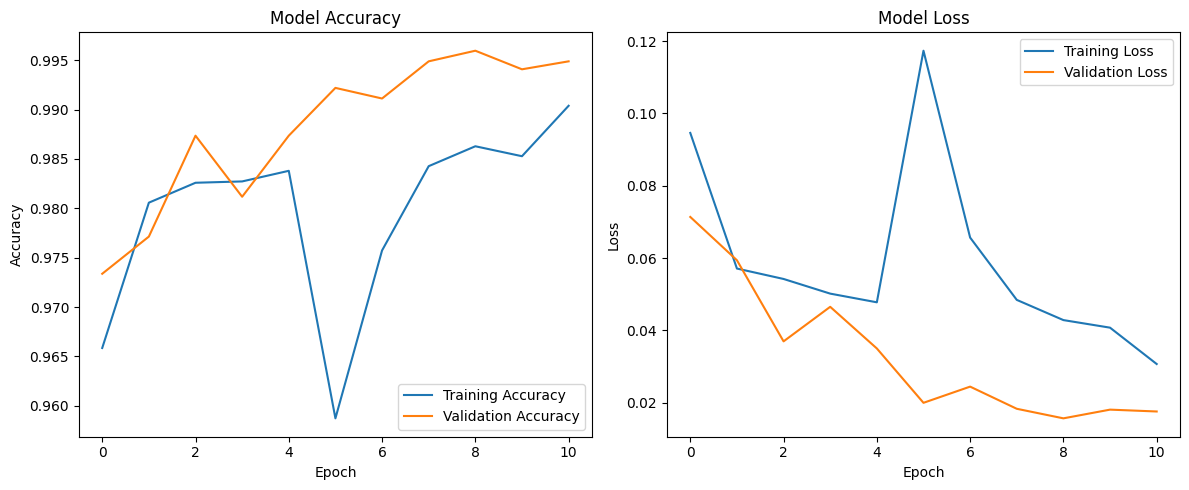

In [ ]:
def plot_training_history(history1, history2=None):

    if history2:

        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
    else:
        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        loss = history1.history['loss']
        val_loss = history1.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))


    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')


    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history_phase1, history_phase2)

**Evaluation**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


# Evaluate model:

evaluation = model.evaluate(validation_generator)
print(f"\nValidation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")
print(f"Validation Precision: {evaluation[2]:.4f}")
print(f"Validation Recall: {evaluation[3]:.4f}")

Found 18595 images belonging to 2 classes.
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9979 - loss: 0.0088 - precision_1: 0.5094 - recall_1: 0.5147

Validation Loss: 0.0157
Validation Accuracy: 0.9960
Validation Precision: 0.9979
Validation Recall: 0.9941


**Prediction System**

In [ ]:
def predict_mask(model, image_path):

    "Predict whether a person is wearing a mask or not"
    try:


        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image from {image_path}")
            return None

        cv2_imshow(img)



        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (IMG_HEIGHT, IMG_WIDTH))
        img_scaled = img_resized / 255.0
        img_reshaped = np.expand_dims(img_scaled, axis=0)


        prediction = model.predict(img_reshaped, verbose=0)[0][0]


        confidence = prediction if prediction > 0.5 else 1 - prediction

        if prediction > 0.5:
            result = "WITHOUT MASK"
            color = (0, 0, 255)
        else:
            result = "WITH MASK"
            color = (0, 255, 0)

        print(f"\nPrediction: {result}")
        print(f"Confidence: {confidence:.2%}")


        # Adding text to image:

        img_with_text = img.copy()
        cv2.putText(img_with_text, f"{result} ({confidence:.1%})",
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2_imshow(img_with_text)

        return prediction

    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

**Test Prediction System**

In [ ]:
print("PREDICTION SYSTEM RESULT :")

image_path = input("Enter the path of the image to be predicted: ")
prediction = predict_mask(model, image_path)


#For multiple images

def predict_batch(model, image_paths):
    "Prediction System Result :"
    predictions = []
    for path in image_paths:
        print(f"\nProcessing: {path}")
        pred = predict_mask(model, path)
        if pred is not None:
            predictions.append(pred)
    return predictions

PREDICTION SYSTEM RESULT :
Enter the path of the image to be predicted: /content/test1.jpg


NameError: name 'predict_mask' is not defined

**Save the model**

In [ ]:
model.save('best_mask_model.h5')
model.save('best_mask_model.keras')
print("\nModel saved successfully!")


Model saved successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


model.save("/content/drive/MyDrive/best_mask_model.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
